# <center>NLP: Topic Modeling for Riyadh Newspaper Articles</center>



**DATA**: We are planning to use our previously **scraped** data from the Riyadh Newspaper website **in Arabic**, ~3GB, plus some additional data (MetaData) that could add a meaningful sense to our project, see [Riyadh Newspaper website](http://www.alriyadh.com/1814297) to understand how we scraped the data.

**EXPECTED OUTPUT**: At the end of this project we expect to be done NLP **Topic Modeling** on Riyadh Newspaper articles, and all it's required preproccesing steps in addition to approperiate visualization.

**BONUS TASKS**: 
- Scraping ~3GB Data. 
- Using SQL Database for data storage. 
- As a challenge, we used data written in Arabic.

In [1]:

import pandas  as pd
import numpy as np

import pyodbc
import unicodedata
import re

from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords # pip install nltk 
# nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

# visualization
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.context('fivethirtyeight');
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams['figure.dpi'] = 150


# 1. Data

### 1.1. Reading from Database

In [2]:
# server=''
# database = '' 
# username = '' 
# password = '' 
# cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
# cursor = cnxn.cursor()

In [3]:
# df = pd.read_sql("select * from articles",cnxn)
# df.to_csv("metadata.csv", encoding='utf-8-sig')

In [4]:
# df= pd.read_sql("select * from texts",cnxn)
# df.to_csv("all_texts.csv",encoding='utf-8-sig')

### 1.2. Texts Dataset

In [5]:
df_texts = pd.read_csv('../Data/all_texts.csv')
df_texts.head(3)

,Unnamed: 0,T_ID,T_AID,T_Text
0,0,87160,174309,\nعلى الرغم من التحذيرات الشديدة والمتكررة الت...
1,1,87164,174317,\nأدى محافظ ضمد عبدالله خالد البراق عقب صلاة ع...
2,2,87165,174319,\nرفع رئيس مجلس إدارة الهيئة العامة للولاية عل...


In [6]:
df_texts.shape

(283762, 4)

### 1.3. Metadata  Dataset

In [7]:
df_metadata = pd.read_csv('../Data/metadata.csv', usecols=['A_ID', 'A_Link', 'A_Cat', 'A_Title1', 'A_Title2', 'A_Words'])
df_metadata.head(3)

,A_ID,A_Link,A_Cat,A_Title1,A_Title2,A_Words
0,1,http://www.alriyadh.com/1814297,المحليات,إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,339
1,2,http://www.alriyadh.com/1814297,المحليات,إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,339
2,3,http://www.alriyadh.com/1814296,المحليات,NaN,تعليم وادي الدواسر يبدأ المرحلة الثانية من خطة...,183


In [8]:
df_metadata.shape

(567524, 6)

### 1.4. Merge  Datasets

In [9]:
# Merging the text dataset and metadata dataset 
df = pd.merge(df_texts, df_metadata, how='inner', left_on='T_AID', right_on='A_ID')
df = df[['T_AID', 'A_Link', 'T_Text', 'A_Cat', 'A_Title1', 'A_Title2', 'A_Words']]
df.head(3)

,T_AID,A_Link,T_Text,A_Cat,A_Title1,A_Title2,A_Words
0,174309,http://www.alriyadh.com/1718990,\nعلى الرغم من التحذيرات الشديدة والمتكررة الت...,المحليات,متهورون يُلقون بمركباتهم في بطون الأودية الممت...,مغامرات السيول.. إلى متى؟,604
1,174317,http://www.alriyadh.com/1718986,\nأدى محافظ ضمد عبدالله خالد البراق عقب صلاة ع...,المحليات,NaN,محافظ ضمد ينقل تعازي القيادة لذوي الشهيد معافا,139
2,174319,http://www.alriyadh.com/1718985,\nرفع رئيس مجلس إدارة الهيئة العامة للولاية عل...,المحليات,NaN,أعضاء هيئة الولاية على أموال القاصرين: نقدر ال...,646


# 2. EDA

### 2.1. Missing Values & Duplicates

In [10]:
# check
print(f'Number of missing values is {df.T_Text.isna().sum()}\nNumber of duplicated rows is {df.T_Text.duplicated().sum()}')

Number of missing values is 6216
Number of duplicated rows is 8121


In [11]:
# drop
df.dropna(subset=['T_Text'], inplace=True)
df.drop_duplicates(subset=['T_Text'], inplace=True)
df.reset_index(drop=True, inplace=True)

### 2.2. Articles Lengths (Words)

In [12]:
# example of USELESS SHORT ARTICLE
# df[df['A_Words'] == 4].iloc[2]['T_Text']

In [13]:
# example of USELESS LONG ARTICLE
# df[df['A_Words'] == df['A_Words'].max()]['T_Text'][151767]

In [14]:
# plot article lengths function
def plot_articles_lenghts():
    sns.histplot(df['A_Words'], bins=70);
    plt.show();

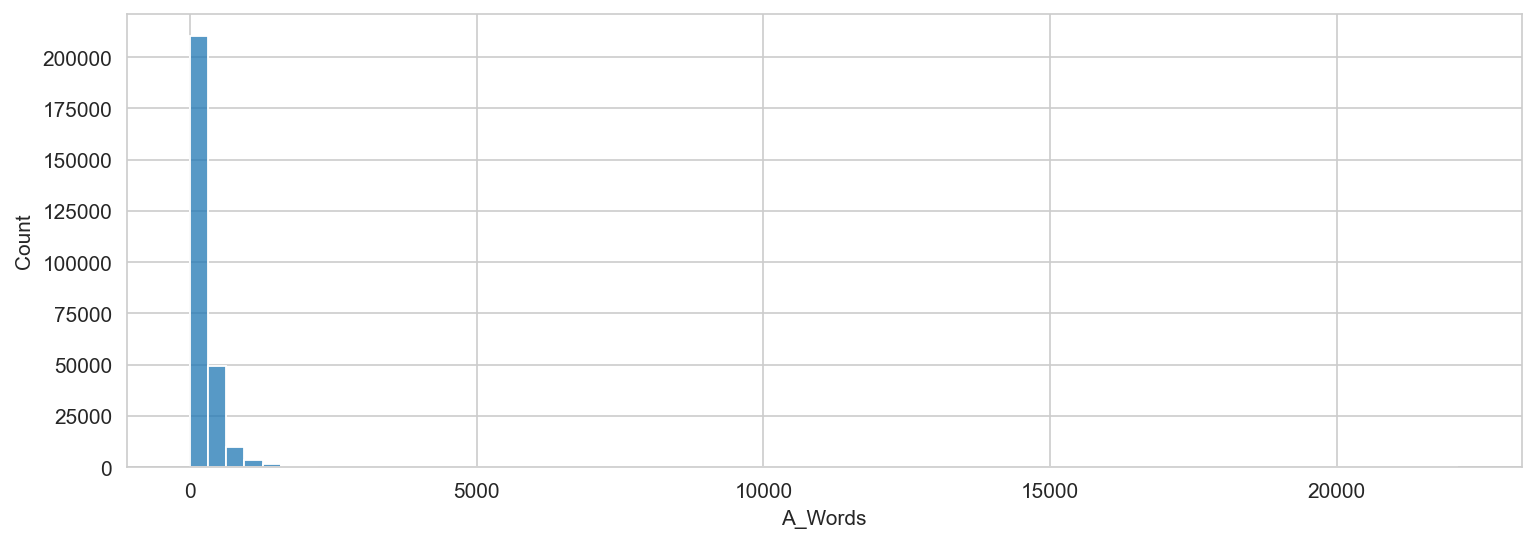

In [15]:
plot_articles_lenghts()

In [16]:
# removing useless articles i.e. very (long/short) texts
df = df[((df['A_Words'] >= 150) & (df['A_Words'] <= 500))].copy()
df.reset_index(drop=True, inplace=True)

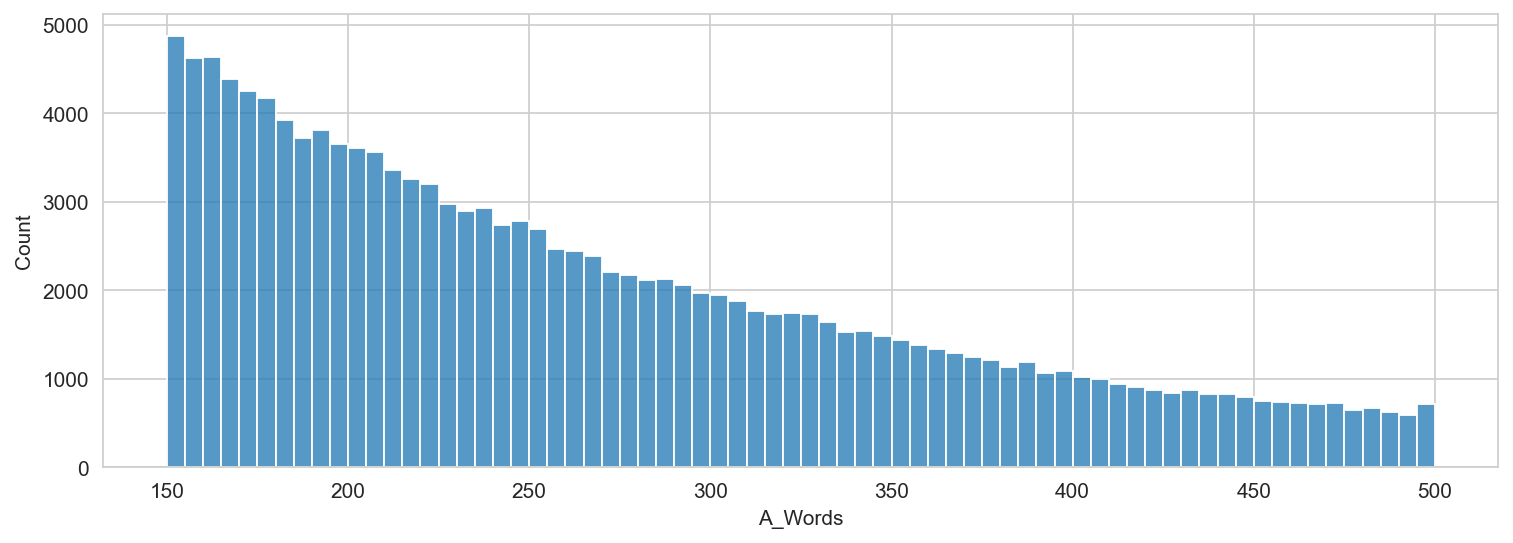

In [17]:
plot_articles_lenghts()

### 2.3. Cleaning Text

In [18]:
# example of an article BEFORE cleaning
df['T_Text'][8]

'\nرعى وزير التعليم\xa0د. أحمد بن محمد العيسى رئيس المؤتمر العام لمكتب التربية العربي لدول الخليج صباح أمس بمقر وزارة التعليم بالرياض احتفالية جائزة مكتب التربية العربي لدول الخليج للعام 1438 -1439هـ في دورتها التاسعة والتي فازت بها مؤسسة الملك عبدالعزيز ورجاله للموهبة والإبداع "موهبة" في مجال التجارب والمشروعات التعليمية.\nوقد حضر الاحتفالية نائب وزير التعليم د. عبدالرحمن محمد العاصمي، والمدير العام لمكتب التربية العربي لدول الخليج د. علي عبدالخالق القرني، والأمين العام لمؤسسة الملك عبدالعزيز ورجاله للموهبة والإبداع د. سعود بن سعيد المتحمي، وعدد من المسؤولين في وزارة التعليم، ومكتب التربية العربي، ومؤسسة الملك عبدالعزيز ورجاله للموهبة والإبداع.\nوفي بداية الاحتفال شاهد الحضور فيلماً مرئياً عن مراحل تأسيس الجائزة وأبرز الأسماء الفائزة (أفرادا ومؤسسات) وطرق التقديم والتحكيم الإلكتروني.\nإثر ذلك ألقى د. القرني كلمة أوضح فيها أن الجائزة في دورتها التاسعة تأتي في إطار دعم الباحثين والمميزين في مجال الدراسات والمشروعات التربوية، والتي كانت من نصيب مؤسسة الملك عبدالعزيز ورجاله للموهبة والإبد

In [19]:
# remove (\n, \xa0..)
df['T_Text'] = df['T_Text'].apply(lambda x: unicodedata.normalize("NFKC", x.replace('\n', ' '))).astype(str)

# remove (non-arabic-alphabet)
df['T_Text'] = df['T_Text'].str.replace('[^ء-ي ]', '')

# replcae (أ,آ,إ) by (ا)
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub('[أإآ]', 'ا', x))

# replace (ة) by (ه)
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub('[ة]', 'ه', x))

# remove multi spaces
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub(' +', ' ', x).strip())

<ipython-input-19-aa8a2db622b9>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['T_Text'] = df['T_Text'].str.replace('[^ء-ي ]', '')


In [20]:
# example of an article AFTER cleaning
df['T_Text'][8]

'رعى وزير التعليم د احمد بن محمد العيسى رئيس المؤتمر العام لمكتب التربيه العربي لدول الخليج صباح امس بمقر وزاره التعليم بالرياض احتفاليه جائزه مكتب التربيه العربي لدول الخليج للعام هـ في دورتها التاسعه والتي فازت بها مؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع موهبه في مجال التجارب والمشروعات التعليميه وقد حضر الاحتفاليه نائب وزير التعليم د عبدالرحمن محمد العاصمي والمدير العام لمكتب التربيه العربي لدول الخليج د علي عبدالخالق القرني والامين العام لمؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع د سعود بن سعيد المتحمي وعدد من المسؤولين في وزاره التعليم ومكتب التربيه العربي ومؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع وفي بدايه الاحتفال شاهد الحضور فيلما مرئيا عن مراحل تاسيس الجائزه وابرز الاسماء الفائزه افرادا ومؤسسات وطرق التقديم والتحكيم الالكتروني اثر ذلك القى د القرني كلمه اوضح فيها ان الجائزه في دورتها التاسعه تاتي في اطار دعم الباحثين والمميزين في مجال الدراسات والمشروعات التربويه والتي كانت من نصيب مؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع ونوه القرني بحرص المكتب على تشجيع ا

# 3. Preprocessing

In [21]:
# helper function
def print_example_text(li):
    ind = li[8].index('اثر')
    print(li[8][:ind])

### 3.1. Tokenization

In [22]:
# done differently using gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list(df['T_Text'].tolist())
data_words = list(sent_to_words(data))

In [23]:
# print
print_example_text(data_words)

['رعى', 'وزير', 'التعليم', 'احمد', 'بن', 'محمد', 'العيسى', 'رييس', 'الموتمر', 'العام', 'لمكتب', 'التربيه', 'العربي', 'لدول', 'الخليج', 'صباح', 'امس', 'بمقر', 'وزاره', 'التعليم', 'بالرياض', 'احتفاليه', 'جايزه', 'مكتب', 'التربيه', 'العربي', 'لدول', 'الخليج', 'للعام', 'هـ', 'في', 'دورتها', 'التاسعه', 'والتي', 'فازت', 'بها', 'موسسه', 'الملك', 'عبدالعزيز', 'ورجاله', 'للموهبه', 'والابداع', 'موهبه', 'في', 'مجال', 'التجارب', 'والمشروعات', 'التعليميه', 'وقد', 'حضر', 'الاحتفاليه', 'نايب', 'وزير', 'التعليم', 'عبدالرحمن', 'محمد', 'العاصمي', 'والمدير', 'العام', 'لمكتب', 'التربيه', 'العربي', 'لدول', 'الخليج', 'علي', 'عبدالخالق', 'القرني', 'والامين', 'العام', 'لموسسه', 'الملك', 'عبدالعزيز', 'ورجاله', 'للموهبه', 'والابداع', 'سعود', 'بن', 'سعيد', 'المتحمي', 'وعدد', 'من', 'المسوولين', 'في', 'وزاره', 'التعليم', 'ومكتب', 'التربيه', 'العربي', 'وموسسه', 'الملك', 'عبدالعزيز', 'ورجاله', 'للموهبه', 'والابداع', 'وفي', 'بدايه', 'الاحتفال', 'شاهد', 'الحضور', 'فيلما', 'مرييا', 'عن', 'مراحل', 'تاسيس', 'الجايزه', 'و

### 3.2. Stop Words Removing + Stemming

In [24]:
stop_words = stopwords.words('arabic')
stop_words.extend(['هـ', 'د', 'م', 'الى', 'ان', 'اذ', 'لهذه', 'قال', 'وقال', 'اكد', 'عدد', 'بعدد', 'وعدد'
                  , 'والتي', 'بن', 'بنت', 'وقد', 'ا', 'عبر', 'خلال', 'او', 'الا', 'وان', 'اي', 'بان', 'كان'
                  , 'كانت' ,'تم','الف','مليون', 'وفي', 'وقد','اكثر','اقل', 'انه','وانه', 'قالت', 'وقالت', 'وتم'])

# stemming as experiment
def apply_stemming_and_Stopwords(texts):
    st = ISRIStemmer()
    return [[st.stem(word) for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
            
data_words_nostops = apply_stemming_and_Stopwords(data_words)
            

In [25]:
# print
print_example_text(data_words_nostops)

['رعى', 'وزر', 'علم', 'حمد', 'حمد', 'عيسى', 'ريس', 'ومر', 'عام', 'كتب', 'ربه', 'عرب', 'لدل', 'خلج', 'امس', 'مقر', 'وزر', 'علم', 'ريض', 'احتفاليه', 'جيز', 'كتب', 'ربه', 'عرب', 'لدل', 'خلج', 'عام', 'دور', 'تسع', 'فزت', 'وسس', 'ملك', 'عبدالعزيز', 'رجل', 'وهب', 'بدع', 'وهب', 'جال', 'جرب', 'شرع', 'علم', 'حضر', 'احتفاليه', 'نيب', 'وزر', 'علم', 'عبدالرحمن', 'حمد', 'عصم', 'دير', 'عام', 'كتب', 'ربه', 'عرب', 'لدل', 'خلج', 'علي', 'عبدالخالق', 'قرن', 'امن', 'عام', 'وسس', 'ملك', 'عبدالعزيز', 'رجل', 'وهب', 'بدع', 'سعد', 'سعد', 'تحم', 'سول', 'وزر', 'علم', 'كتب', 'ربه', 'عرب', 'وسس', 'ملك', 'عبدالعزيز', 'رجل', 'وهب', 'بدع', 'بدي', 'حفل', 'شهد', 'حضر', 'فيل', 'مري', 'رحل', 'اسس', 'جيز', 'برز', 'سمء', 'فيز', 'فرد', 'وسس', 'طرق', 'قدم', 'حكم', 'كترو']


### 3.3. Bigrams

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [27]:
# print
print_example_text(data_words_bigrams)

['رعى', 'وزر', 'علم', 'حمد', 'حمد', 'عيسى', 'ريس', 'ومر', 'عام', 'كتب', 'ربه', 'عرب', 'لدل', 'خلج', 'امس', 'مقر', 'وزر', 'علم', 'ريض', 'احتفاليه', 'جيز', 'كتب', 'ربه', 'عرب', 'لدل', 'خلج', 'عام', 'دور', 'تسع', 'فزت', 'وسس', 'ملك', 'عبدالعزيز', 'رجل', 'وهب', 'بدع', 'وهب', 'جال', 'جرب', 'شرع', 'علم', 'حضر', 'احتفاليه', 'نيب', 'وزر', 'علم', 'عبدالرحمن', 'حمد', 'عصم', 'دير', 'عام', 'كتب', 'ربه', 'عرب', 'لدل', 'خلج', 'علي', 'عبدالخالق', 'قرن', 'امن', 'عام', 'وسس', 'ملك', 'عبدالعزيز', 'رجل', 'وهب', 'بدع', 'سعد', 'سعد', 'تحم', 'سول', 'وزر', 'علم', 'كتب', 'ربه', 'عرب', 'وسس', 'ملك', 'عبدالعزيز', 'رجل', 'وهب', 'بدع', 'بدي', 'حفل', 'شهد', 'حضر', 'فيل', 'مري', 'رحل', 'اسس', 'جيز', 'برز', 'سمء', 'فيز', 'فرد', 'وسس', 'طرق', 'قدم', 'حكم', 'كترو']


# 4. Encoding (id2word)

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
 
# Create Corpus
texts = data_words_bigrams
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 4), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 3), (35, 2), (36, 2), (37, 1), (38, 3), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 4), (45, 5), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 2), (54, 1), (55, 1), (56, 3), (57, 1), (58, 3), (59, 1), (60, 4), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 2), (79, 1), (80, 1), (81, 2), (82, 2), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)]]


# 5. Topic Modeling (LDA)

In [29]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
# Print the Keyword in topics
#pprint(lda_model.print_topics(40,10))
x = lda_model.print_topics(40,10)
terms = []
for u in range(0,40):
    y = lda_model.show_topic(u,10)
    yz = [yo[0] for yo in y]
    terms.append(yz)
df_topics = pd.DataFrame(terms)
df_topics = df_topics.transpose()
# doc_lda = lda_model[corpus]

In [31]:
df_topics.iloc[:,25:40]

,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,ملك,ندي,عمل,خلف,شرك,وطن,عرب,ريس,بحر,لعب,سكن,شرك,طقه,يمن,حكم
1,جلس,ريض,درب,هيه,قطع,الل,دول,امر,سعد,هدف,اسر,هرج,امر,حوث,تهم
2,دول,تحد,رنمج,بلغ,ثمر,ملك,رهب,جلس,ملك,دور,جمع,عرض,سمه,قوت,صدر
3,شرك,ديه,رمج,صدر,سوق,سلم,ملك,نخب,بعث,فرق,شرع,سوق,شرع,عسكر,سجن
4,علم,سعد,علم,طبق,بنك,خدم,قطر,حزب,ريس,برا,وزر,ملك,حفظ,حلف,قضه
5,سعد,لعب,هدف,نظم,اله,حفظ,سلم,رمب,تصل,نقط,فيد,سعد,عمل,يلش,قضي
6,ريس,قدم,طور,رقب,عام,شرف,شعب,تحد,جمهور,قدم,عقر,علم,قصم,ليش,نفذ
7,تعا,دره,وطن,جره,سعد,عهد,سيس,جمع,صدق,نخب,خير,كبر,سمو,شرع,حقق
8,جال,ريس,شرك,قيم,عمل,حرم,وقف,ولي,فخم,سجل,رنمج,جدد,خدم,حفظ,جني
9,ومر,عقد,وسس,رخص,صرف,عبدالعزيز,دعم,رنس,شعب,فوز,اسك,تمر,بلد,سلح,قتل


# 5. Evaluation

In [32]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.235064749084589
Coherence Score:  0.4494841040918279


# 6. Finding Optimal Number of Topics

In [33]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=False)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
 
    return model_list, coherence_values

In [34]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=50, step=6)

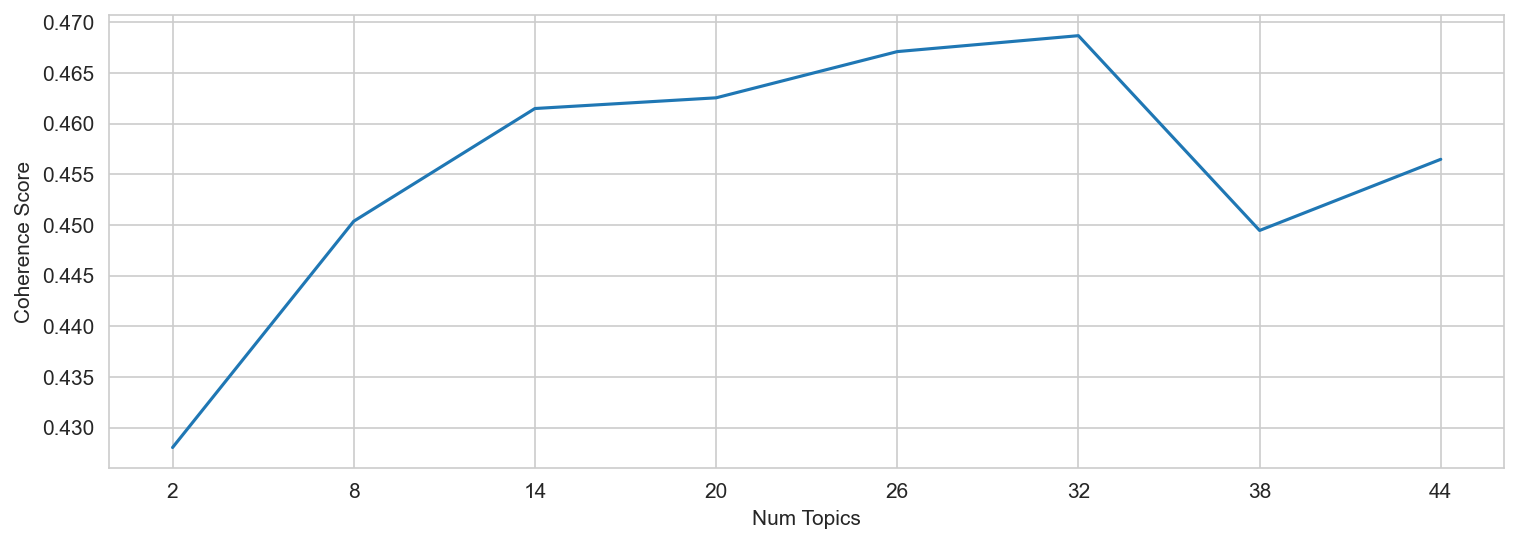

In [35]:
# Show graph
x = range(2, 50, 6)
sns.lineplot(x=x, y=coherence_values)
plt.xlabel("Num Topics")
plt.ylabel('Coherence Score')
plt.xticks(x)
plt.show()

# 7. Merging Genres, Articles Titles with LDA Results

In [36]:
# # Store the documents' topic vectors in a list so we can take a peak
# lda_docs = [doc for doc in lda_model[corpus]]

In [37]:
# # get a dataframe with topic A_ID to merge it
# df6 = pd.DataFrame(columns=['ArticleID','TopicID','Perc'], dtype='object')
# def func(x):
#     #pass
#     #print(x['index'])
#     global df6
#     for x1 in x['D']:
#         #print(x1[1])
#         #df6.iloc[-1] = [0,x1[0],x1[1]]
#         df6 = df6.append(pd.DataFrame(columns=['ArticleID','TopicID','Perc'], data=[[x['index'], x1[0], x1[1]]]))
#         #df6.index = df6.index+1


# df5 = pd.DataFrame(columns=['D'], data=zip(lda_docs))
# #a = np.array(lda_docs[2])
# #a[:,1].max()

# #df5['Perc'] = df5['D'].apply(lambda x:list(zip(x))[0][0][1])
# df5 = df5.reset_index()
# df5.apply(lambda x: func(x), axis=1)

# df5.head()
# df6.head()

In [38]:
# # merge article, topic id, and article title, genre in original frame
# df7 = pd.merge(df6,df,how='left',left_on='ArticleID',right_on='index')
# df7[df7['TopicID']==9][['ArticleID','TopicID','Perc','A_Cat','A_Title1','A_Title2','T_Text']]


# #df7.head()
# #df7.to_csv("articles_Topics1.csv",encoding='utf-8-sig')
# df7.shape